In [1]:
import numpy as np, matplotlib.pyplot as plt
%matplotlib inline

# Set font size for plotting
font = {'size':14}
plt.rc('font', **font)

# Import RomPy
import rompy as rp

In [2]:
import lal
import lalsimulation as lalsim

In [3]:
?lalsim.SimInspiralChooseFDWaveform

Docstring: SimInspiralChooseFDWaveform(REAL8 const m1, REAL8 const m2, REAL8 const S1x, REAL8 const S1y, REAL8 const S1z, REAL8 const S2x, REAL8 const S2y, REAL8 const S2z, REAL8 const distance, REAL8 const inclination, REAL8 const phiRef, REAL8 const longAscNodes, REAL8 const eccentricity, REAL8 const meanPerAno, REAL8 const deltaF, REAL8 const f_min, REAL8 const f_max, REAL8 f_ref, Dict LALpars, Approximant const approximant) -> int
Type:      builtin_function_or_method


In [4]:
def gen_wf_params(
        m1=50,
        m2=50,
        S1x=0,
        S1y=0,
        S1z=0,
        S2x=0,
        S2y=0,
        S2z=0,
        distance=1,
        inclination=0,
        phiRef=0,
        longAscNodes=0,
        eccentricity=0,
        meanPerAno=0,
        deltaF=1,
        f_min=30,
        f_max=400,
        f_ref=30,
        LALpars=None,
        approximant=lalsim.IMRPhenomD):
    
    
    p=dict(
        m1=m1,
        m2=m2,
        S1x=S1x,
        S1y=S1y,
        S1z=S1z,
        S2x=S2x,
        S2y=S2y,
        S2z=S2z,
        distance=distance,
        inclination=inclination,
        phiRef=phiRef,
        longAscNodes=longAscNodes,
        eccentricity=eccentricity,
        meanPerAno=meanPerAno,
        deltaF=deltaF,
        f_min=f_min,
        f_max=f_max,
        f_ref=f_ref,
        LALpars=LALpars,
        approximant=approximant)
    
    return p
    

In [5]:
def gen_wf(p):
    
    p.update({'m1':p['m1']*lal.MSUN_SI})
    p.update({'m2':p['m2']*lal.MSUN_SI})
    
    hp, _ = lalsim.SimInspiralChooseFDWaveform(**p)
    
    
    f = np.arange(hp.data.length) * hp.deltaF
    
    mask = (f >= p['f_min']) & (f < p['f_max'])
    
    hp = hp.data.data[mask]
    f = f[mask]
    
    amp = np.abs(hp)
    phase = np.unwrap(np.angle(hp))
    
    return f, hp, amp, phase

In [6]:
p = gen_wf_params()
f, hp, amp, phase = gen_wf(p)

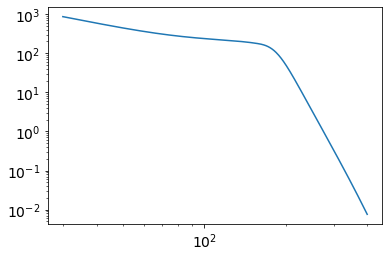

In [7]:
plt.figure()

plt.plot(f, amp)
plt.yscale('log')
plt.xscale('log')

In [8]:
plt.figure()

plt.plot(f, phase)
# plt.yscale('log')
# plt.xscale('log')

# define training set

In [9]:
import phenom

In [10]:
M = 100
qlist = np.linspace(1, 10, 100)

In [11]:
m1list, m2list = phenom.m1_m2_M_q(M, qlist)

In [137]:
params = []
coords = []
for q in qlist:
    m1, m2 = phenom.m1_m2_M_q(M, q)

    p = gen_wf_params(m1=m1, m2=m2)
    f, hp, amp, phase = gen_wf(p)
    d = {"M":M, "q":q, "c":c, "f":f, "phase":phase}
    params.append(d)
    coords.append(q)
        
coords = np.array(coords)

In [138]:
training = np.zeros(shape=(len(params), len(params[0]['f'])))

In [139]:
training.shape

(100, 370)

In [140]:
for i, pp in enumerate(params):
    training[i] = pp['phase']

In [141]:
int_range = [params[0]['f'][0], params[0]['f'][-1]]
int_num = len(params[0]['f'])

In [142]:
integration = rp.Integration(int_range, num=int_num, rule='trapezoidal')

In [143]:
sur = rp.Surrogate(integration)

In [144]:
sur.MakeROM(training, 0, 1e-12)

>>> Warning(Index already selected): Exiting greedy algorithm.


In [145]:
print("Basis size =", sur.rb.size)

Basis size = 18


In [146]:
plt.plot(sur.rb.errors)
plt.yscale('log')

In [147]:
sur.MakeFits(coords, fit='spline', deg=5)

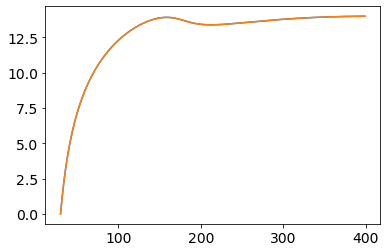

In [150]:
plt.figure()
plt.plot(integration.nodes, sur.Eval(1))
plt.plot(integration.nodes, training[0])

In [151]:
plt.figure()
plt.plot(integration.nodes, sur.Eval(1)-training[0])

In [152]:
%%timeit
sur.Eval(1)

119 µs ± 6.41 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [153]:
%%timeit
p = gen_wf_params(m1=50, m2=50)
f, hp, amp, phase = gen_wf(p)

191 µs ± 8.93 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [154]:
M=100
q=9.99
m1, m2 = phenom.m1_m2_M_q(M, q)
p = gen_wf_params(m1=m1, m2=m2)
f, hp, amp, phase = gen_wf(p)

sur_phase = sur.Eval(q)

In [155]:
plt.figure()
plt.plot(f, sur_phase)
plt.plot(f, phase)

In [156]:
plt.figure()
plt.plot(f, sur_phase-phase)